# LangGraph Components

Based on [**this tutorial**](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/3/langgraph-components)

# Setup

In [1]:
from dotenv import load_dotenv

In [2]:
_ = load_dotenv()

# Imports

In [26]:
import operator
from typing import Annotated, List, TypedDict
from rich import print as rprint

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import (AnyMessage,
                                     HumanMessage,
                                     SystemMessage,
                                     ToolMessage)
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END


# Documentation About Imports

Here are some links for further documentation about imports.

- `typing` will be useful to perform type hints (which will surely be used, under the hood, by `pydantic`, to perform data validation)
    - [**TypedDict**](https://mypy.readthedocs.io/en/stable/typed_dict.html) helps give type hints for values.
    - [**Annotated**](https://docs.python.org/fr/3.9/library/typing.html#typing.Annotated)

# Concepts of LangGraph

## Overview

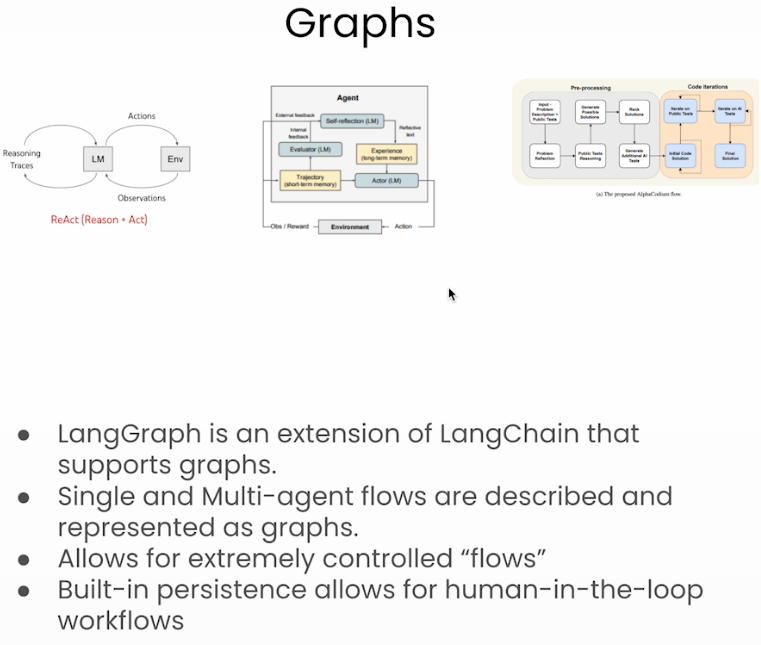

## Basic Components

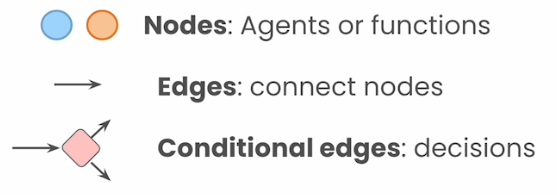

## Last Example Workflow

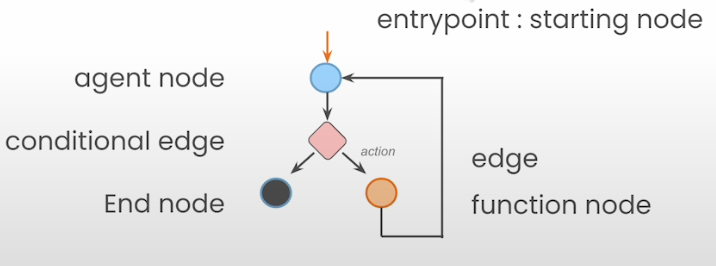

## Agent's State

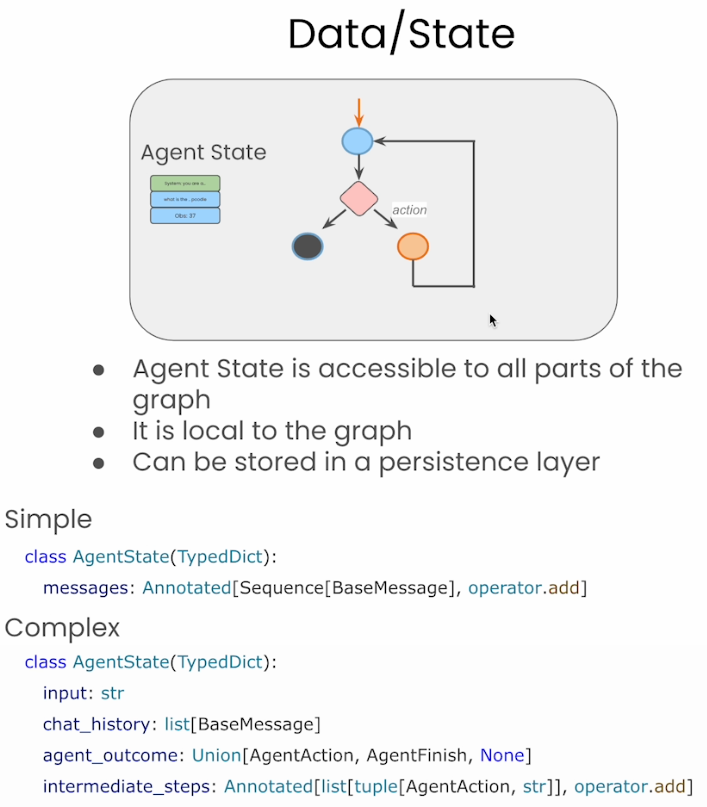

# Code

## Schema

Here's a schema illustrating what we're gonna code:

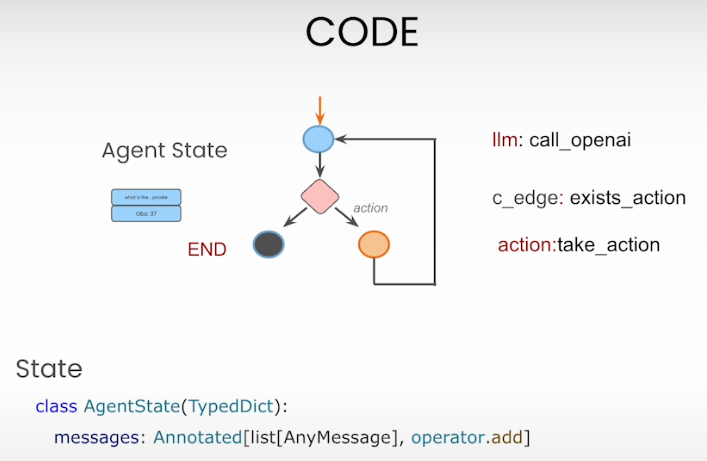

In [4]:
# Instanciating the search tool
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> **NOTE**
> 
> Knowing the tool's name is useful as it will be used in the workflow for logging purposes.

## `AgentState`

In [6]:
class AgentState(TypedDict):
    """Obviously, this class will record the agent's state as a typed dictionary"""
    messages: Annotated[list[AnyMessage], operator.add]

> **NOTE**
> 
> The `AgentState` class is defined as a dictionary with one key: `messages`. The value type for `messages` is a `list` of `AnyMessage` objects (his class has only been imported for type hints purpose).
>
> The `Annotated` type from the `typing` module is used to **add metadata to the `messages` field**. In this case, the metadata is `operator.add`, which is a function that adds two objects together. This metadata is not used in the standard Python library, but **it can be used by third-party libraries or tools that understand this metadata**.
> 
> Here, it explains that **when the state is updated, it isn't overridden, but new messages are added to the state**.

## `Agent`

In [8]:
class Agent:
    """
    This class has essentially 3 methods, each implemented within a graph element:
    - `call_openai` to call the model, within the "llm" node;
    - `exists_action` to check if an action is present, within the conditional edge;
    - `take_action` to perform an action, within the "action" node.
    """

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",  # Starting node
            self.exists_action,  # Decision function
            # Map decision function's output to the name of the next node
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()  # Define the graph as a LangChain Runnable
        self.tools = {t.name: t for t in tools}  # For logging purposes
        self.model = model.bind_tools(tools)  # Let the model know available tools

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content = self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling {t}")
            if t["name"] not in self.tools:
                # Fallback if the LLM hallucinated, and called a non-existent tool
                print("\n ....Bad tool name....")
                result = "Bad tool name, retry."
            else:
                result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(
                tool_call_id = t["id"],
                name = t["name"],
                content = str(result)
                )
            )
        # Logging the 'feedback' loop
        print("Back to the model!")
        return {"messages": results}
    
    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0


In [15]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!"""
model = ChatOpenAI(model="gpt-4-turbo")
abot = Agent(model, [tool], system=prompt)

## Some Introspection

### `Agent`

In [16]:
# List non dunder attributes and methods
[item for item in dir(abot) if item[0] != "_"]

['call_openai',
 'exists_action',
 'graph',
 'model',
 'system',
 'take_action',
 'tools']

In [17]:
abot.system

'You are a smart research assistant. Use the search engine to look up information. You are allowed to make multiple calls (either together or in sequence). Only look up information when you are sure of what you want. If you need to look up some information before asking a follow up question, you are allowed to do that!'

In [18]:
abot.tools

{'tavily_search_results_json': TavilySearchResults(max_results=4)}

## Agent Graph

In [31]:
type(abot.graph)

langgraph.graph.state.CompiledStateGraph

In [30]:
# graph object
rprint(abot.graph)

CompiledStateGraph(
    nodes={
        '__start__': PregelNode(
            config={'tags': ['langsmith:hidden']},
            channels=['__start__'],
            triggers=['__start__'],
            writers=[
                ChannelWrite<messages>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object 
object at 0x7914942ebb90>, skip_none=False, mapper=_get_state_key(recurse=False))], 
require_at_least_one_of=['messages']),
                ChannelWrite<start:llm>(recurse=True, writes=[ChannelWriteEntry(channel='start:llm', 
value='__start__', skip_none=False, mapper=None)], require_at_least_one_of=None)
            ]
        ),
        'llm': PregelNode(
            config={'tags': []},
            channels={'messages': 'messages'},
            triggers=['action', 'start:llm'],
            mapper=functools.partial(<function _coerce_state at 0x791462ba1d00>, <class '__main__.AgentState'>),
            writers=[
                ChannelWrite<llm,messages>(recurse=True, writes=[ChannelWriteEntry(channel='llm', value='llm', 
skip_none=False, mapper=None), ChannelWriteEntry(channel='messages', value=<object object at 0x7914942ebb90>, 
skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages']),
                _route(recurse=True, _is_channel_writer=True)
            ]
        ),
        'action': PregelNode(
            config={'tags': []},
            channels={'messages': 'messages'},
            triggers=['branch:llm:exists_action:action'],
            mapper=functools.partial(<function _coerce_state at 0x791462ba1d00>, <class '__main__.AgentState'>),
            writers=[
                ChannelWrite<action,messages>(recurse=True, writes=[ChannelWriteEntry(channel='action', 
value='action', skip_none=False, mapper=None), ChannelWriteEntry(channel='messages', value=<object object at 
0x7914942ebb90>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['messages'])
            ]
        )
    },
    channels={
        'messages': <langgraph.channels.binop.BinaryOperatorAggregate object at 0x791462707f50>,
        '__start__': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x79147caa5a90>,
        'llm': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x7914627b4110>,
        'action': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x7914627b6450>,
        'start:llm': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x7914627b6a90>,
        'branch:llm:exists_action:action': <langgraph.channels.ephemeral_value.EphemeralValue object at 
0x791462706750>
    },
    auto_validate=False,
    stream_mode='updates',
    output_channels=['messages'],
    stream_channels=['messages'],
    input_channels='__start__',
    builder=<langgraph.graph.state.StateGraph object at 0x791462705910>
)

### Display

> **NOTE**
>
> Using this may not work as you need to use `pygraphviz` (added to requirements).
> 
> **BUT**, according to the [**INSTALL.txt**](https://github.com/pygraphviz/pygraphviz/blob/main/INSTALL.txt) on pygraphviz's GitHub, you may have to install additional packages on Linux with `sudo apt-get install graphviz graphviz-dev` before installing with `pip`.
> 
> If this still doesn't work, you may have to perform `sudo apt-get install python-dev` or, if you've got several versions of Python on your computer `sudo apt-get install python3.x-dev`, `x` being the version you used to define your virtual environment.
> 
> All this finally worked for me, I've alas no idea what may cause any further issue...

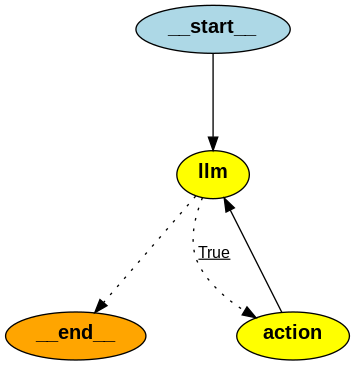

In [20]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [28]:
# What object was previously drawn
rprint(abot.graph.get_graph())

DrawableGraph(
    nodes={
        '__start__': Node(id='__start__', data=<class 'pydantic.v1.main.LangGraphInput'>),
        '__end__': Node(id='__end__', data=<class 'pydantic.v1.main.LangGraphOutput'>),
        'llm': Node(id='llm', data=llm(recurse=True)),
        'action': Node(id='action', data=action(recurse=True))
    },
    edges=[
        Edge(source='__start__', target='llm', data=None, conditional=False),
        Edge(source='action', target='llm', data=None, conditional=False),
        Edge(source='llm', target='action', data=True, conditional=True),
        Edge(source='llm', target='__end__', data=False, conditional=True)
    ]
)

### Further Introspection

In [22]:
[item for item in dir(abot.graph) if item[0] != "_"]

['Config',
 'InputType',
 'OutputType',
 'abatch',
 'abatch_as_completed',
 'aget_state',
 'aget_state_history',
 'ainvoke',
 'assign',
 'astream',
 'astream_events',
 'astream_log',
 'atransform',
 'attach_branch',
 'attach_edge',
 'attach_node',
 'aupdate_state',
 'auto_validate',
 'batch',
 'batch_as_completed',
 'bind',
 'builder',
 'channels',
 'checkpointer',
 'config_schema',
 'config_specs',
 'config_type',
 'configurable_alternatives',
 'configurable_fields',
 'construct',
 'copy',
 'debug',
 'dict',
 'from_orm',
 'get_graph',
 'get_input_schema',
 'get_lc_namespace',
 'get_name',
 'get_output_schema',
 'get_prompts',
 'get_state',
 'get_state_history',
 'input_channels',
 'input_schema',
 'interrupt_after_nodes',
 'interrupt_before_nodes',
 'invoke',
 'is_lc_serializable',
 'json',
 'lc_attributes',
 'lc_id',
 'lc_secrets',
 'managed_values_dict',
 'map',
 'name',
 'nodes',
 'output_channels',
 'output_schema',
 'parse_file',
 'parse_obj',
 'parse_raw',
 'pick',
 'pipe',
 're

> **One state is relative to its `config`**.

In [24]:
try:
    abot.graph.get_state()
except Exception as e:
    print(e)

Pregel.get_state() missing 1 required positional argument: 'config'


## Some Experiments

### Experiment 1 (Simple)

In [46]:
# Some informative logs will be triggered
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})
# Then, let's pretty print the final state in result
rprint(result)

Calling {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_WbSktt1g5TwAGdUiJ5LK0RLR'}
Back to the model!


{
    'messages': [
        HumanMessage(content='What is the weather in sf?'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_WbSktt1g5TwAGdUiJ5LK0RLR',
                        'function': {
                            'arguments': '{"query":"current weather in San Francisco"}',
                            'name': 'tavily_search_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'token_usage': {'completion_tokens': 22, 'prompt_tokens': 153, 'total_tokens': 175},
                'model_name': 'gpt-4-turbo',
                'system_fingerprint': 'fp_31a6c0accf',
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-49437836-edbb-47a0-9dfc-7b66e5584d85-0',
            tool_calls=[
                {
                    'name': 'tavily_search_results_json',
                    'args': {'query': 'current weather in San Francisco'},
                    'id': 'call_WbSktt1g5TwAGdUiJ5LK0RLR'
                }
            ],
            usage_metadata={'input_tokens': 153, 'output_tokens': 22, 'total_tokens': 175}
        ),
        ToolMessage(
            content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San 
Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': 
-122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1718138227, \'localtime\': \'2024-06-11 13:37\'},
\'current\': {\'last_updated_epoch\': 1718137800, \'last_updated\': \'2024-06-11 13:30\', \'temp_c\': 23.3, 
\'temp_f\': 73.9, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': 
\'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 9.4, \'wind_kph\': 15.1, 
\'wind_degree\': 350, \'wind_dir\': \'N\', \'pressure_mb\': 1012.0, \'pressure_in\': 29.88, \'precip_mm\': 0.0, 
\'precip_in\': 0.0, \'humidity\': 62, \'cloud\': 0, \'feelslike_c\': 25.0, \'feelslike_f\': 77.1, \'windchill_c\': 
19.0, \'windchill_f\': 66.2, \'heatindex_c\': 19.0, \'heatindex_f\': 66.2, \'dewpoint_c\': 11.0, \'dewpoint_f\': 
51.7, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 5.0, \'gust_mph\': 14.9, \'gust_kph\': 23.9}}"}, {\'url\': 
\'https://www.weather.gov/index.php/mtr/\', \'content\': \'Last Map Update: Fri, Jun 7, 2024 at 11:14:49 pm PDT 
Watches, Warnings & Advisories. Zoom Out. Small Craft Advisory. ... (Selected product opens in current window) 
Social Media. San Francisco Radar. Sacramento Radar. ... National Weather Service San Francisco Bay Area, CA 21 
Grace Hopper Ave, Stop 5 Monterey, CA 93943-5505\'}, {\'url\': 
\'https://forecast.weather.gov/MapClick.php?lat=37.61961&lon=-122.36558\', \'content\': \'Current conditions at San
Francisco, San Francisco International Airport (KSFO) Lat: 37.61961°NLon: ... 2am PDT Jun 11, 2024-6pm PDT Jun 17, 
2024 . Forecast Discussion . Additional Resources. ... National Weather Service; San Francisco Bay Area, CA; 21 
Grace Hopper Ave, Stop 5; Monterey, CA 93943-5505; Comments? Questions?\'}, {\'url\': 
\'https://www.timeanddate.com/weather/usa/san-francisco\', \'content\': \'Current weather in San Francisco and 
forecast for today, tomorrow, and next 14 days\'}]',
            name='tavily_search_results_json',
            tool_call_id='call_WbSktt1g5TwAGdUiJ5LK0RLR'
        ),
        AIMessage(
            content='The current weather in San Francisco is sunny with a temperature of 73.9°F (23.3°C). The wind 
is blowing from the north at about 9.4 mph (15.1 kph), and the humidity is at 62%. There are no clouds in the sky, 
and the atmospheric pressure is 1012.0 mb.',
            response_metadata={
                'token_usage': {'completion_tokens': 73, 'prompt_tokens': 866, 'total_tokens': 939

In [47]:
def display_messages_contents():
    for idx, msg in enumerate(result["messages"]):
        rprint("Message", idx)
        rprint(type(msg))
        rprint(msg.content)

In [48]:
display_messages_contents()

Message 0

<class 'langchain_core.messages.human.HumanMessage'>

What is the weather in sf?

Message 1

<class 'langchain_core.messages.ai.AIMessage'>

Message 2

<class 'langchain_core.messages.tool.ToolMessage'>

[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 
'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 
'localtime_epoch': 1718138227, 'localtime': '2024-06-11 13:37'}, 'current': {'last_updated_epoch': 1718137800, 
'last_updated': '2024-06-11 13:30', 'temp_c': 23.3, 'temp_f': 73.9, 'is_day': 1, 'condition': {'text': 'Sunny', 
'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 9.4, 'wind_kph': 15.1, 
'wind_degree': 350, 'wind_dir': 'N', 'pressure_mb': 1012.0, 'pressure_in': 29.88, 'precip_mm': 0.0, 'precip_in': 
0.0, 'humidity': 62, 'cloud': 0, 'feelslike_c': 25.0, 'feelslike_f': 77.1, 'windchill_c': 19.0, 'windchill_f': 
66.2, 'heatindex_c': 19.0, 'heatindex_f': 66.2, 'dewpoint_c': 11.0, 'dewpoint_f': 51.7, 'vis_km': 16.0, 
'vis_miles': 9.0, 'uv': 5.0, 'gust_mph': 14.9, 'gust_kph': 23.9}}"}, {'url': 
'https://www.weather.gov/index.php/mtr/', 'content': 'Last Map Update: Fri, Jun 7, 2024 at 11:14:49 pm PDT Watches,
Warnings & Advisories. Zoom Out. Small Craft Advisory. ... (Selected product opens in current window) Social Media.
San Francisco Radar. Sacramento Radar. ... National Weather Service San Francisco Bay Area, CA 21 Grace Hopper Ave,
Stop 5 Monterey, CA 93943-5505'}, {'url': 'https://forecast.weather.gov/MapClick.php?lat=37.61961&lon=-122.36558', 
'content': 'Current conditions at San Francisco, San Francisco International Airport (KSFO) Lat: 37.61961°NLon: ...
2am PDT Jun 11, 2024-6pm PDT Jun 17, 2024 . Forecast Discussion . Additional Resources. ... National Weather 
Service; San Francisco Bay Area, CA; 21 Grace Hopper Ave, Stop 5; Monterey, CA 93943-5505; Comments? Questions?'}, 
{'url': 'https://www.timeanddate.com/weather/usa/san-francisco', 'content': 'Current weather in San Francisco and 
forecast for today, tomorrow, and next 14 days'}]

Message 3

<class 'langchain_core.messages.ai.AIMessage'>

The current weather in San Francisco is sunny with a temperature of 73.9°F (23.3°C). The wind is blowing from the 
north at about 9.4 mph (15.1 kph), and the humidity is at 62%. There are no clouds in the sky, and the atmospheric 
pressure is 1012.0 mb.

> **NOTE**
> 
> There's no content within the message 1 because it's an `AIMessage` whose purpose is to perform a **tool call**

In [39]:
rprint(result["messages"][1].tool_calls)

[
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'current weather in San Francisco'},
        'id': 'call_sG01TcfppxXFrE3tYTXX3Upp'
    }
]

In [43]:
# Response (content of the final message)
rprint(result['messages'][-1].content)

The current weather in San Francisco is sunny with a temperature of 80.1°F (26.7°C). The wind is blowing from the 
northwest at 8.1 mph (13.0 kph), and the humidity is at 45%. There are no clouds, and the visibility is good at 9 
miles (16 km).

### Experiment 2: Parallel Searches

In [50]:
# Only logs
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco today'}, 'id': 'call_aVyM3h7OxT3qtrRcZ0CX5z4L'}
Calling {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles today'}, 'id': 'call_3RAxrVfP6P0CrIyiYHhgaOd8'}
Back to the model!


In [51]:
display_messages_contents()

Message 0

<class 'langchain_core.messages.human.HumanMessage'>

What is the weather in SF and LA?

Message 1

<class 'langchain_core.messages.ai.AIMessage'>

Message 2

<class 'langchain_core.messages.tool.ToolMessage'>

[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 
'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 
'localtime_epoch': 1718138227, 'localtime': '2024-06-11 13:37'}, 'current': {'last_updated_epoch': 1718137800, 
'last_updated': '2024-06-11 13:30', 'temp_c': 23.3, 'temp_f': 73.9, 'is_day': 1, 'condition': {'text': 'Sunny', 
'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 9.4, 'wind_kph': 15.1, 
'wind_degree': 350, 'wind_dir': 'N', 'pressure_mb': 1012.0, 'pressure_in': 29.88, 'precip_mm': 0.0, 'precip_in': 
0.0, 'humidity': 62, 'cloud': 0, 'feelslike_c': 25.0, 'feelslike_f': 77.1, 'windchill_c': 19.0, 'windchill_f': 
66.2, 'heatindex_c': 19.0, 'heatindex_f': 66.2, 'dewpoint_c': 11.0, 'dewpoint_f': 51.7, 'vis_km': 16.0, 
'vis_miles': 9.0, 'uv': 5.0, 'gust_mph': 14.9, 'gust_kph': 23.9}}"}, {'url': 
'https://www.mercurynews.com/2024/06/11/quick-bake-in-store-for-bay-area-as-inland-temperatures-to-threaten-100/', 
'content': 'June 11, 2024 at 7:38 a.m. A gradual, intense warm-up of temperatures throughout the inland portion of 
the Bay Area will culminate Tuesday with a quick boil that will leave triple digits lining ...'}, {'url': 
'https://www.accuweather.com/en/us/san-francisco/94103/june-weather/347629', 'content': 'Get the monthly weather 
forecast for San Francisco, CA, including daily high/low, historical averages, to help you plan ahead.'}, {'url': 
'https://world-weather.info/forecast/usa/san_francisco/june-2024/', 'content': 'Extended weather forecast in San 
Francisco. Hourly Week 10 days 14 days 30 days Year. Detailed ⚡ San Francisco Weather Forecast for June 2024 - 
day/night 🌡️ temperatures, precipitations - World-Weather.info.'}]

Message 3

<class 'langchain_core.messages.tool.ToolMessage'>

[{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Los Angeles', 'region': 'California', 
'country': 'United States of America', 'lat': 34.05, 'lon': -118.24, 'tz_id': 'America/Los_Angeles', 
'localtime_epoch': 1718138232, 'localtime': '2024-06-11 13:37'}, 'current': {'last_updated_epoch': 1718137800, 
'last_updated': '2024-06-11 13:30', 'temp_c': 18.3, 'temp_f': 64.9, 'is_day': 1, 'condition': {'text': 'Overcast', 
'icon': '//cdn.weatherapi.com/weather/64x64/day/122.png', 'code': 1009}, 'wind_mph': 10.5, 'wind_kph': 16.9, 
'wind_degree': 260, 'wind_dir': 'W', 'pressure_mb': 1014.0, 'pressure_in': 29.93, 'precip_mm': 0.0, 'precip_in': 
0.0, 'humidity': 76, 'cloud': 100, 'feelslike_c': 18.3, 'feelslike_f': 64.9, 'windchill_c': 24.9, 'windchill_f': 
76.8, 'heatindex_c': 25.5, 'heatindex_f': 77.8, 'dewpoint_c': 12.1, 'dewpoint_f': 53.8, 'vis_km': 16.0, 
'vis_miles': 9.0, 'uv': 7.0, 'gust_mph': 15.0, 'gust_kph': 24.1}}"}, {'url': 
'https://www.accuweather.com/en/us/los-angeles/90012/june-weather/347625', 'content': 'Get the monthly weather 
forecast for Los Angeles, CA, including daily high/low, historical averages, to help you plan ahead.'}, {'url': 
'https://world-weather.info/forecast/usa/los_angeles/june-2024/', 'content': 'Extended weather forecast in Los 
Angeles. Hourly Week 10 days 14 days 30 days Year. Detailed ⚡ Los Angeles Weather Forecast for June 2024 - 
day/night 🌡️ temperatures, precipitations - World-Weather.info.'}, {'url': 
'https://www.timeanddate.com/weather/usa/los-angeles/ext', 'content': 'Los Angeles 14 Day Extended Forecast. 
Weather Today Weather Hourly 14 Day Forecast Yesterday/Past Weather Climate (Averages) Currently: 69 °F. Sunny. 
(Weather station: Hawthorne Municipal Airport, USA). See more current weather.'}]

Message 4

<class 'langchain_core.messages.ai.AIMessage'>

Here's the current weather information for San Francisco and Los Angeles:

**San Francisco:**
- **Temperature:** 23.3°C (73.9°F)
- **Conditions:** Sunny
- **Wind:** 9.4 mph, coming from the North
- **Humidity:** 62%
- **Visibility:** 16 km (9 miles)
- **UV Index:** 5

**Los Angeles:**
- **Temperature:** 18.3°C (64.9°F)
- **Conditions:** Overcast
- **Wind:** 10.5 mph, coming from the West
- **Humidity:** 76%
- **Visibility:** 16 km (9 miles)
- **UV Index:** 7

This data provides a snapshot of the weather conditions in both cities as of the most recent update.

> **NOTE**
> 
> Notice that the result if formatted in MarkDown!

In [52]:
from rich.console import Console
from rich.markdown import Markdown

In [53]:
console = Console()
markdown = Markdown(result['messages'][-1].content)
console.print(markdown)

Here's the current weather information for San Francisco and Los Angeles:                                          

San Francisco:                                                                                                     

 • Temperature: 23.3°C (73.9°F)                                                                                    
 • Conditions: Sunny                                                                                               
 • Wind: 9.4 mph, coming from the North                                                                            
 • Humidity: 62%                                                                                                   
 • Visibility: 16 km (9 miles)                                                                                     
 • UV Index: 5                                                                                                     

Los Angeles:                                                                                                       

 • Temperature: 18.3°C (64.9°F)                                                                                    
 • Conditions: Overcast                                                                                            
 • Wind: 10.5 mph, coming from the West                                                                            
 • Humidity: 76%                                                                                                   
 • Visibility: 16 km (9 miles)                                                                                     
 • UV Index: 7                                                                                                     

This data provides a snapshot of the weather conditions in both cities as of the most recent update.

### Experiment 3: Parallel Searches

In [54]:
messages = [HumanMessage(content="Where is it the hottest between SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling {'name': 'tavily_search_results_json', 'args': {'query': 'current temperature in San Francisco'}, 'id': 'call_RONqMncVXbLSHoMkAUzXVuD1'}
Calling {'name': 'tavily_search_results_json', 'args': {'query': 'current temperature in Los Angeles'}, 'id': 'call_F0FKjP82dqid1f6wDGvsSZjl'}
Back to the model!


In [55]:
display_messages_contents()

Message 0

<class 'langchain_core.messages.human.HumanMessage'>

Where is it the hottest between SF and LA?

Message 1

<class 'langchain_core.messages.ai.AIMessage'>

Message 2

<class 'langchain_core.messages.tool.ToolMessage'>

[{'url': 'https://www.accuweather.com/en/us/san-francisco/94103/weather-forecast/347629', 'content': 'Today. 6/11. 
73° · Some clouds, then sunshine ; Wed. 6/12. 64° · Mostly sunny and cooler ; Thu. 6/13. 63° · Clouds giving way to
sun ; Fri. 6/14. 69° · Breezy in the\xa0...'}, {'url': 'https://weather.com/weather/today/l/USCA0987:1:US', 
'content': 'Weather Today in San Francisco, CA. Feels Like57°. 5:47 am. 8:32 pm. High / Low. 73°/53°. Wind. 3 mph. 
Humidity. 84%. Dew Point. 52°. Pressure. 29.90 in.'}, {'url': 
'https://weather.com/weather/tenday/l/San+Francisco+CA+USCA0987:1:US', 'content': "Comfy & Cozy\nThat's Not What 
Was Expected\nOutside\n'No-Name Storms' In Florida\nGifts From On High\nWhat To Do For Wheezing\nSurviving The 
Season\nStay Safe\nAir Quality Index\nAir quality is considered satisfactory, and air pollution poses little or no 
risk.\n Health & Activities\nSeasonal Allergies and Pollen Count Forecast\nNo pollen detected in your area\nCold & 
Flu Forecast\nFlu risk is low in your area\nWe recognize our responsibility to use data and technology for good. 
recents\nSpecialty Forecasts\n10 Day Weather-San Francisco, CA\nToday\nMon 18 | Day\nConsiderable cloudiness. Wed 
27\nWed 27 | Day\nConsiderable cloudiness with occasional rain showers. Fri 29\nFri 29 | Day\nRain showers in the 
morning with scattered thunderstorms arriving in the afternoon."}, {'url': 
'https://www.wunderground.com/weather/us/ca/san-francisco', 'content': "Updated just now. 73° | 53°. 68 °F. like 
68°. icon. Sunny. N. 0. Today's temperature is forecast to be WARMER than yesterday. Radar; Satellite. 
WunderMap|Nexrad."}]

Message 3

<class 'langchain_core.messages.tool.ToolMessage'>

[{'url': 'https://forecast.weather.gov/MapClick.php?lat=33.9436&lon=-118.408', 'content': 'Downtown Los Angeles 
Weather Station has Moved; ... Current conditions at Los Angeles, Los Angeles International Airport (KLAX) Lat: 
33.93806°NLon: 118.38889°WElev: 125.0ft. Mostly Cloudy. 60°F. 16°C. Humidity: 89%: Wind Speed: W 5 MPH: Barometer: 
29.94 in (1013.89 mb) Dewpoint:'}, {'url': 'https://www.wunderground.com/weather/us/ca/los-angeles', 'content': 
'Find out the current and future weather conditions for Los Angeles, CA with Weather Underground, the most reliable
source for local and long-range forecasts, weather reports, maps and tropical ...'}, {'url': 
'https://www.accuweather.com/en/us/los-angeles/90012/current-weather/347625', 'content': 'Get the latest weather 
information for Los Angeles, CA, including temperature, humidity, wind, pressure, and cloud cover. See the forecast
for tonight and the next 10 days.'}, {'url': 
'https://weather.com/weather/today/l/Los+Angeles+CA?canonicalCityId=84c64154109916077c8d3c2352410aaae5f6eeff682000e
3a7470e38976128c2', 'content': "Today's and tonight's Los Angeles, CA weather forecast, weather conditions and 
Doppler radar from The Weather Channel and Weather.com"}]

Message 4

<class 'langchain_core.messages.ai.AIMessage'>

Currently, it is hotter in San Francisco with a temperature of 73°F, compared to Los Angeles where the temperature 
is 60°F.